In [11]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [12]:
from FBSNNs import *
from CallOption import *

In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 8192  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 2 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([0.5] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4
lr = 1e-3

In [33]:
n_iter = 11 * 10 ** 2
lr = 1e-5

In [34]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 19900, Loss: 7.903e-01, Y0: 0.179, Time: 0.18, Learning Rate: 1.000e-05
It: 20000, Loss: 1.109e+00, Y0: 0.178, Time: 17.51, Learning Rate: 1.000e-05
It: 20100, Loss: 4.994e-01, Y0: 0.181, Time: 17.48, Learning Rate: 1.000e-05
It: 20200, Loss: 4.943e-01, Y0: 0.180, Time: 17.52, Learning Rate: 1.000e-05
It: 20300, Loss: 1.427e+00, Y0: 0.181, Time: 17.44, Learning Rate: 1.000e-05
It: 20400, Loss: 5.932e-01, Y0: 0.182, Time: 17.37, Learning Rate: 1.000e-05
It: 20500, Loss: 7.872e-01, Y0: 0.180, Time: 17.18, Learning Rate: 1.000e-05
It: 20600, Loss: 5.730e-01, Y0: 0.180, Time: 17.62, Learning Rate: 1.000e-05
It: 20700, Loss: 5.751e-01, Y0: 0.181, Time: 17.34, Learning Rate: 1.000e-05
It: 20800, Loss: 4.588e-01, Y0: 0.181, Time: 17.61, Learning Rate: 1.000e-05
It: 20900, Loss: 5.989e-01, Y0: 0.180, Time: 17.34, Learning Rate: 1.000e-05
total time: 191.83544850349426 s


In [40]:
model.load_model("models/CallOption4.pth")

In [41]:
graph = model.iteration, model.training_loss

In [68]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

In [25]:
from scipy.stats import multivariate_normal as normal

In [58]:
X_pred = X_pred.sum(axis=2)

In [69]:
X_preds1 = X_pred[:,:,0]

In [70]:
X_preds2 = X_pred[:,:,1]

In [60]:
Y_preds = Y_pred.reshape(8192,51)

In [72]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 0.5     # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test1 = calculate_option_prices(X_preds1, t_test[0], K, r, sigma, T, q)

/tmp/ipykernel_2330776/4014227456.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [73]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 0.5     # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test2 = calculate_option_prices(X_preds2, t_test[0], K, r, sigma, T, q)

/tmp/ipykernel_2330776/3254946035.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [74]:
Y_test = Y_test1 + Y_test2

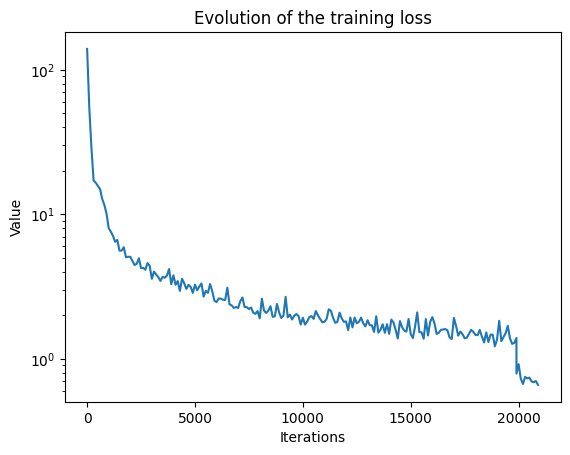

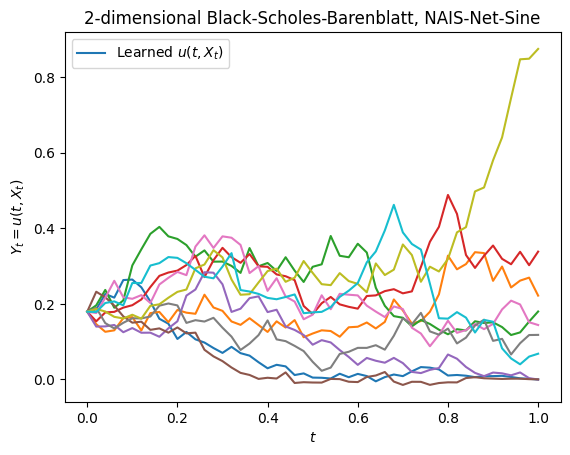

In [75]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 10
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

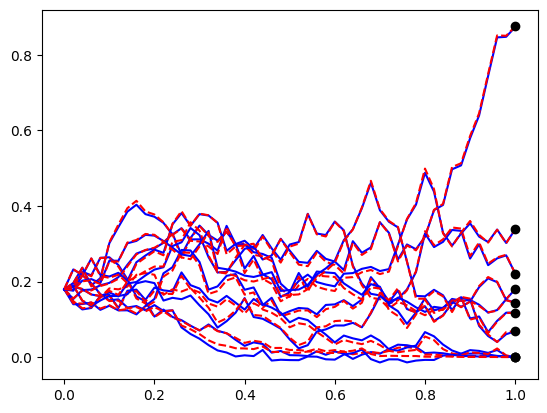

In [80]:
for i in range(10):
    plt.plot(t_test[i], Y_preds[i], 'b', label='Learned $u(t,X_t)$')
    plt.plot(t_test[i], Y_test[i], 'r--', label='Exact $u(t,X_t)$')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko', label='$Y_T = u(T,X_T)$')
plt.show()

In [87]:
errors = (Y_test - Y_preds) ** 2
errors.mean(), errors.std()

(0.00010185143334561934, 0.00023652488154824358)

In [88]:
Y_pred.shape

(8192, 51, 1)

In [89]:
r = 0.05

In [90]:
Y_preds = Y_pred.reshape(8192,51)

In [91]:
time_stamps = t_test[0].reshape(51,)
time_stamps

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32)

In [92]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0)    
epe

array([0.17916526, 0.17871347, 0.17844974, 0.17867531, 0.17857814,
       0.17897491, 0.17931254, 0.1791702 , 0.17964219, 0.17952923,
       0.17929177, 0.17949915, 0.17935649, 0.17976509, 0.17980957,
       0.17917001, 0.179938  , 0.17940097, 0.17943673, 0.18001999,
       0.18060058, 0.18090129, 0.18083781, 0.18084165, 0.1806167 ,
       0.18030944, 0.18063402, 0.18085   , 0.18107568, 0.18081284,
       0.1813    , 0.18167245, 0.18109085, 0.18105432, 0.18141347,
       0.1815103 , 0.1810147 , 0.18036675, 0.1803397 , 0.180209  ,
       0.18070573, 0.18063015, 0.18148832, 0.18182595, 0.18249086,
       0.1818374 , 0.18200041, 0.18149963, 0.1815258 , 0.18175355,
       0.18226606], dtype=float32)

In [93]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -8.7249282e-07,
       -6.7807414e-06, -1.6004416e-05, -3.6069268e-05, -4.6870162e-05,
       -8.1336475e-05, -1.0499700e-04, -1.4146540e-04, -1.8247627e-04,
       -2.1863922e-04, -2.6100242e-04, -3.2646940e-04, -3.6218192e-04,
       -4.2044427e-04, -4.5561980e-04, -5.1925844e-04, -5.8134261e-04,
       -6.4605160e-04, -7.3344499e-04, -8.1096619e-04, -8.9611398e-04,
       -9.3871064e-04, -9.8710682e-04, -1.0482877e-03, -1.0891630e-03,
       -1.1182838e-03, -1.1366985e-03, -1.1290421e-03, -1.1492235e-03,
       -1.1443004e-03, -1.1264419e-03, -1.0928368e-03, -1.0440663e-03,
       -9.6084009e-04, -8.3450862e-04, -7.0722675e-04, -5.7099789e-04,
       -4.4349203e-04, -3.3359084e-04, -2.4201292e-04, -1.6013796e-04,
       -9.2468785e-05, -4.1489951e-05, -4.4660876e-05], dtype=float32)

In [94]:
s=1.0 # spot price
k=1.0 # strike price
r=0.05 # risk-free rate
sigma=0.4 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [95]:
call 

0.18022951450216668

In [96]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

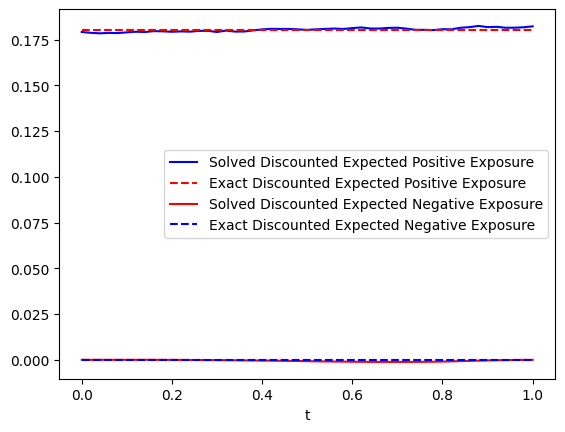

In [97]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [98]:
model.save_model("models/CallOption4.pth")